In [12]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from code import inverse_problem as inv 
from code import direct_problem as direct 

In [13]:
def geological_environment(params):
    matrix=params[0]*np.ones((int(sum(params[1::2])*1.25), int(sum(params[1::2])*1.25)))
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            for k in range(0,int(len(params)/2+1/2)):
                if sum(params[1:2*k:2])<i<=sum(params[1:2*(k+1):2]):
                    matrix[i][j]=params[2*k]
            if sum(params[1:2*k:2])<i:
                matrix[i][j]=params[2*k]
    return matrix

In [14]:
rmin,rmax=0.1,10**4
r=np.logspace(np.log10(rmin),np.log10(rmax),50)
rho0,h0,rhoN=50,20,200
rho1,rho2,thickness,N=100,1,5,5
param=[rho0,h0] + [rho1,thickness, rho2,thickness]*N +[rhoN]
method='U'

resistance=[]
for r_i in r:
    resistance.append(direct.calculate_apparent_resistance(param,method,r_i,10*int(1+r_i/200))) 

In [15]:
start=[[rho0,h0] + [(rho1*rho2)**0.5, 2*N*thickness] + [rhoN]]

bound=[[(max(0,rho0-0.0),rho0+0.0), (max(0,h0-0),h0+0)] + [(1/(N/rho1+N/rho2),N*(rho1+rho2)), (0,1000)] + [(max(0,rhoN-0.0),rhoN+0.0)]]

In [16]:
#bound[0][3]=(2*N*thickness,2*N*thickness)
bound

[[(50.0, 50.0),
  (20, 20),
  (0.19801980198019803, 505),
  (0, 1000),
  (200.0, 200.0)]]

35.54511314510897 Ом
72.93828504693604 %


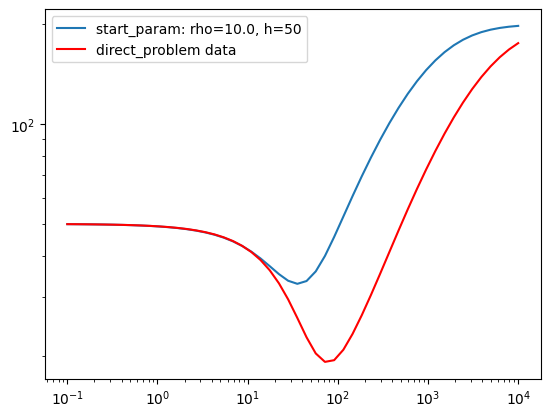

In [17]:
rk_start=[]
for r_i in r:
    rk_start.append(direct.calculate_apparent_resistance(start[0],method,r_i,num_of_zeros=10*int(1+r_i/200)))
rk_start=np.array(rk_start)
plt.loglog(r,rk_start, label=f'start_param: rho={start[0][2]}, h={start[0][3]}')
plt.loglog(r,resistance,c='red', label='direct_problem data')
plt.legend()
print(inv.RMSE(rk_start,resistance),'Ом')
print(inv.RMSPE(rk_start,resistance),'%')

In [18]:
N_layers_list=[3]
loss='RMSPE'
minim='L-BFGS-B'
inverse=inv.inverse_problem_solver(N_layers_list,method, np.array([r,resistance]).T, minimization_method=minim, loss_type=loss, start=start,boundaries=bound) 
results=inverse[0] # модели полученные из обратной задачи 
ind=inverse[1] #  индекс модели с наименьшим loss_N_layers в results
print(ind)

0


In [19]:
#Вывод количества слоёв в модели, её параметров и полученной ошибки
t=''
if loss=="RMSPE": t='%'
if loss=="RMSE": t='Ом'
for i in range (len(N_layers_list)):
    print('\nnumber of layers= ', N_layers_list[i], '\nparam =', results[i].x, f'\nloss {loss} =', results[i].fun,t)


number of layers=  3 
param = [ 50.          20.          13.14966137 346.29113815 200.        ] 
loss RMSPE = 3.8709350031602905 %


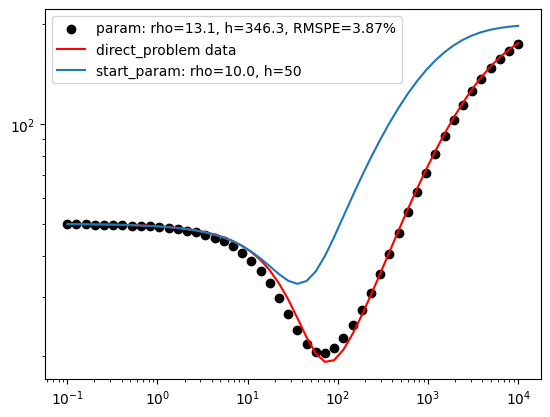

In [20]:
# Визуализация
for i in range(len(N_layers_list)):
    rk=[]
    for r_i in r:
        rk.append(direct.calculate_apparent_resistance(results[i].x,method,r_i,num_of_zeros=10*int(1+r_i/200)))
    rk=np.array(rk)
    if i==ind:
        plt.scatter(r,rk, c='black',label=f'param: rho={round(results[i].x[2],1)}, h={round(results[i].x[3],1)}, {loss}={round(results[i].fun,2)}{t}')
    else: plt.loglog(r,rk, label=f'{N_layers_list[i]}_layers')
plt.loglog(r,resistance,c='red', label='direct_problem data')
plt.loglog(r,rk_start, label=f'start_param: rho={start[0][2]}, h={start[0][3]}')
plt.legend()

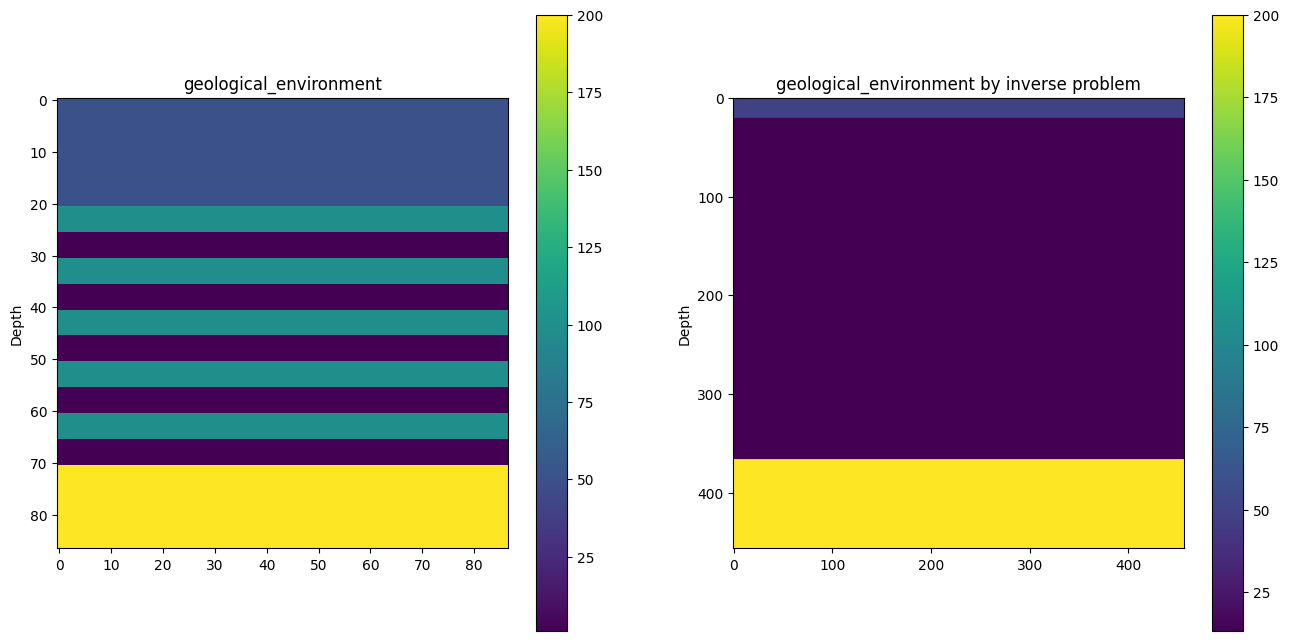

In [41]:
fig=plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.imshow(geological_environment(param))
plt.ylabel('Depth')
plt.title('geological_environment')
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(geological_environment(list(results[0].x)))
plt.ylabel('Depth')
plt.title('geological_environment by inverse problem')
plt.colorbar()

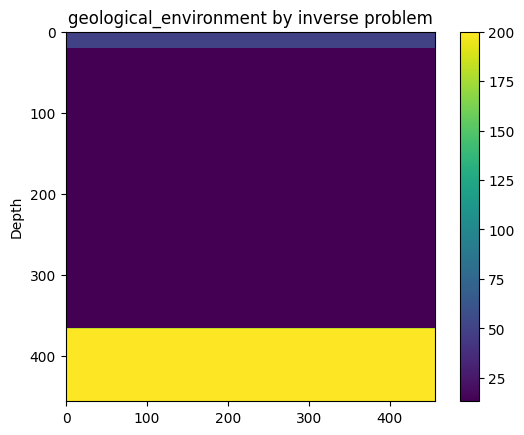

In [26]:
plt.imshow(geological_environment(list(results[0].x)))
plt.ylabel('Depth')
plt.title('geological_environment by inverse problem')
plt.colorbar()